In [1]:
import ss_deterministic_model
import torch

import statsmodels.api as sm
from statsmodels.tsa.statespace.representation import Representation
from statsmodels.tsa.statespace import kalman_smoother
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib widget

In [2]:
u_torch, x_torch, y_torch = ss_deterministic_model.benchmark_data()
# u, x, y = u_torch.numpy(), x_torch.numpy(), (y_torch+0.01*torch.randn_like(y_torch)).squeeze(-1).numpy()
u, x, y = u_torch.numpy(), x_torch.numpy(), y_torch.squeeze(-1).numpy()

### Select a single sequence from the batch
First dimension is used as batch index.

In [3]:
endog = y[0, :]
exog = u[0, :]

In [4]:
# We could also fit a more complicated model with seasonal components.
# As an example, here is an SARIMA(1,1,1) x (0,1,1,4):
# Fit the model with a fixed value for the AR(1) coefficient using the
# context manager
mod_sarimax = sm.tsa.SARIMAX(endog, exog=exog, order=(3, 0, 0), trend='n')
# with mod_sarimax.fix_params({'ar.L1': 0.5}):
res_sarimax = mod_sarimax.fit(maxiter=1500)

# Show the summary of results
print(res_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(3, 0, 0)   Log Likelihood                  98.590
Date:                Thu, 06 Jan 2022   AIC                           -187.180
Time:                        18:29:04   BIC                           -173.039
Sample:                             0   HQIC                          -181.435
                                - 125                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5221      0.018    -29.405      0.000      -0.557      -0.487
ar.L1          2.5802      0.055     46.798      0.000       2.472       2.688
ar.L2         -2.2938      0.138    -16.648      0.0

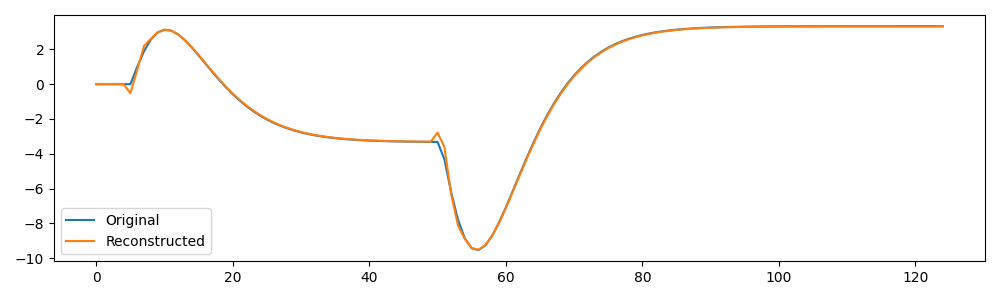

In [5]:
pred = res_sarimax.predict()

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(y[0, :, 0], label='Original')
ax.plot(pred, label='Reconstructed')
ax.legend()

# ax[1].plot(x_rec.squeeze(), label='Reconstructed states')
fig.tight_layout()

In [6]:
pd.DataFrame(res_sarimax.model.ssm.state_intercept)

,0
0,0.0
1,0.0
2,0.0


array([[[1.]],

       [[0.]],

       [[0.]]])

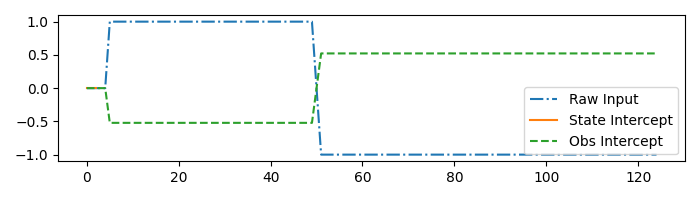

In [17]:
# type(res_sarimax.model.ssm)
# res_sarimax.model.ssm.design
# pd.DataFrame(res_sarimax.model.ssm.transition.squeeze())
fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(exog, linestyle='-.', label='Raw Input')
ax.plot(res_sarimax.model.ssm.state_intercept.squeeze(), linestyle='-', label='State Intercept')
ax.plot(res_sarimax.model.ssm.obs_intercept.squeeze(), linestyle='--', label='Obs Intercept')
ax.legend()
fig.tight_layout()
res_sarimax.model.ssm.selection

In [8]:
lags=3
n_inputs = u.shape[2]
n_outputs = y.shape[2]
# Load your (multivariate) dataset
# endog = pd.read_csv('your/dataset/here.csv')

# Fit a local level model
# mod_var1 = sm.tsa.VARMAX(endog=endog, exog=exog, order=(1,0))
mod_var1 = sm.tsa.AutoReg(endog=endog, exog=exog, lags=lags, trend='n')
# Note that mod_var1 is an instance of the VARMAX class

# Fit the model via maximum likelihood
res_var1 = mod_var1.fit()
# Note that res_var1 is an instance of the VARMAXResults class

# Show the summary of results
print(res_var1.summary())

# Construct impulse responses
# irfs = res_ll.impulse_responses(steps=10)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  125
Model:                   AutoReg-X(3)   Log Likelihood                  54.852
Method:               Conditional MLE   S.D. of innovations              0.154
Date:                Thu, 06 Jan 2022   AIC                            -99.704
Time:                        18:29:05   BIC                            -85.683
Sample:                             3   HQIC                           -94.009
                                  125                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           2.3169      0.080     29.087      0.000       2.161       2.473
y.L2          -1.7980      0.154    -11.658      0.000      -2.100      -1.496
y.L3           0.4735      0.080      5.955      0.0

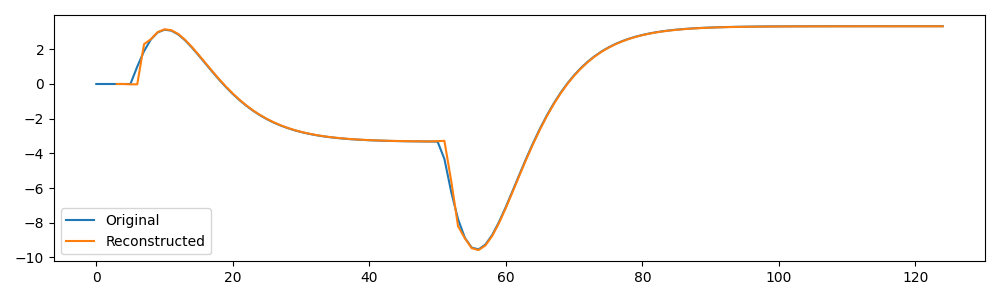

In [9]:
pred = res_var1.predict()

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(y[0, :, 0], label='Original')
ax.plot(pred, label='Reconstructed')
ax.legend()

# ax[1].plot(x_rec.squeeze(), label='Reconstructed states')
fig.tight_layout()

In [10]:
A = torch.diag(torch.ones(lags-1), -1)
A[0, :] = torch.tensor(res_var1.params[0:lags])
B = torch.zeros(lags, n_inputs)
B[0, :] = torch.tensor(res_var1.params[lags:])
C = torch.zeros(n_outputs, lags)
C[:, 0:n_outputs] = torch.eye(n_outputs)

reconstructed = ss_deterministic_model.StateSpaceModel(A, B, C)
x_rec, y_rec = reconstructed.simulate(u_torch[0:1])
